In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as py
from scipy import asarray as ar,exp
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns
from sklearn.metrics import r2_score
import statsmodels.api as sm

Define parameters:

In [2]:
dataset_selected = "tcga:tcga-brca_female"
y_column = "num_edges"

Create test dataset:

In [3]:
topology_results_file = '/home/j.aguirreplans/Projects/Scipher/SampleSize/scripts/SampleSizeShiny/data/example_pearson_pval_0.05/topology_results_norm_divide.L_pearson_pval_0.05.txt'
df = pd.read_csv(topology_results_file)[["type_dataset", "size", "rep", "num_edges", "unnorm"]].sort_values(by = ["type_dataset", "size", "rep"]).rename(columns = {"num_edges" : "num_edges_norm", "unnorm" : "num_edges"})
df = df[df['type_dataset'] == dataset_selected]
df.head()

,type_dataset,size,rep,num_edges_norm,num_edges
1065,tcga:tcga-brca_female,20,1,0.000231,42227
1066,tcga:tcga-brca_female,20,2,0.000402,73434
1067,tcga:tcga-brca_female,20,3,0.000231,42190
1068,tcga:tcga-brca_female,20,4,0.000253,46246
1069,tcga:tcga-brca_female,20,5,0.000388,70826


In [4]:
#df = pd.read_csv("/home/j.aguirreplans/comparison_power_law.txt")
#df = df[df["model"] == "Mean"][["type_dataset", "size", "rep", "num_edges"]].sort_values(by = ["type_dataset", "size", "rep"])
#df

Calculate the mean across different repetitions for each size:

In [5]:
Sn = df.groupby('size').mean()[[y_column]]
Sn.head()

,num_edges
size,
20,54984.6
40,300197.2
60,909776.8
80,1721919.2
100,3331005.4


Create a lagged variable:

In [6]:
Sn_min_1 = Sn.shift(1)
Sn_min_1.head()

,num_edges
size,
20,NaN
40,54984.6
60,300197.2
80,909776.8
100,1721919.2


Calculate (Sn - Sn-1) / Sn-1:

In [7]:
#Sn_Snlag_diff = Sn.diff()
#func = Sn_Snlag_diff / Sn
func = (Sn - Sn_min_1) / Sn_min_1
func.head()

,num_edges
size,
20,NaN
40,4.459660
60,2.030597
80,0.892683
100,0.934473


Define the size (x axis) and the number of edges (y axis):

In [8]:
sizes = func[func[y_column] > 0].index
sizes

Int64Index([  40,   60,   80,  100,  120,  140,  160,  180,  200,  220,  240,
             260,  280,  300,  340,  380,  400,  420,  460,  480,  500,  520,
             540,  580,  600,  620,  640,  660,  700,  720,  780,  800,  840,
             880,  900,  940, 1000, 1020, 1060, 1080],
           dtype='int64', name='size')

In [9]:
num_edges = func[func[y_column] > 0][y_column]
num_edges.head()

size
40     4.459660
60     2.030597
80     0.892683
100    0.934473
120    0.295325
Name: num_edges, dtype: float64

Now we will fit the data into two different models: exponential decay and power law. The procedure to fit these models is explained in this [website](https://www.physics.drexel.edu/~valliere/PHYS160/Textbook/Chapter_6/6.6.4.html).

We fit the data into a **exponential decay** model:

$\ y = b * exp(-lambda * n) $

How? By using the natural logarithm in both sides of the equation, we are able to derive the following formula:

$\ ln(y) = ln(b) - lambda * n $

If we apply a linear regression into the data using $\ ln(y) $ vs. $\ n $, we can get the values of lambda and b from the values of the slope and intercept:

$\ lambda = -slope $

$\ b = exp(intercept) $

In [10]:
exp_decay_fit = np.polyfit(
    sizes,
    np.log(num_edges),
    1
)
exp_decay_slope = exp_decay_fit[0]
exp_decay_intercept = exp_decay_fit[1]
exp_decay_lambda = -exp_decay_slope
exp_decay_b = np.exp(exp_decay_intercept)
print(f"Exponential decay fit --> lambda = {exp_decay_lambda}; b = {exp_decay_b}")

Exponential decay fit --> lambda = 0.0034473962839244557; b = 0.45771029701635646


We fit the data into a **power law** model:

$\ y = b * n^{alpha} $

How? By using the natural logarithm in both sides of the equation, we are able to derive the following formula:

$\ ln(y) = ln(b) + alpha * ln(n) $

If we apply a linear regression into the data using $\ ln(y) $ vs. $\ ln(n) $, we can get the values of alpha and b from the values of the slope and intercept:

$\ alpha = slope $

$\ b = exp(intercept) $

In [11]:
power_law_decay_fit = np.polyfit(
    np.log(sizes),
    np.log(num_edges),
    1
)
power_law_slope = power_law_decay_fit[0]
power_law_intercept = power_law_decay_fit[1]
power_law_alpha = power_law_slope
power_law_b = np.exp(power_law_intercept)
print(f"Power law fit --> alpha = {power_law_alpha}; b = {power_law_b}")

Power law fit --> alpha = -1.4684246340142346; b = 503.2872298098774


Now, we'll make plot comparing the different models:

0.12
0.74
0.0


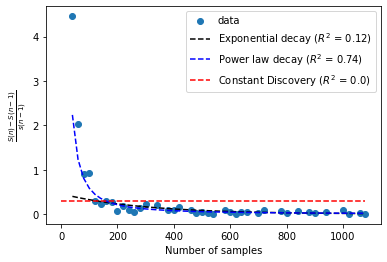

In [13]:
# Calculate the values of the exponential decay model
num_edges_exp_decay = exp_decay_b * np.exp(-exp_decay_lambda * sizes)

# Calculate the R2 score of the exponential decay model
r2_exp_decay = round(r2_score(num_edges, num_edges_exp_decay), 2)
print(r2_exp_decay)

# Calculate the values of the power law decay model
num_edges_power_law = power_law_b * sizes**(power_law_alpha)

# Calculate the R2 score of the power law decay model
r2_power_law = round(r2_score(num_edges, num_edges_power_law), 2)
print(r2_power_law)

# Plot size vs. number of edges
plt.scatter(
    x = sizes,
    y = num_edges, label = 'data'
)

# Plot the exponential decay model
plt.plot(
    sizes,
    num_edges_exp_decay,
    'k--',
    label = f'Exponential decay ($R^2$ = {str(r2_exp_decay)})'
)

# Plot the power law decay model
plt.plot(
    sizes,
    num_edges_power_law,
    'b--',
    label = f'Power law decay ($R^2$ = {str(r2_power_law)})'
)

# Plot a line (using mean(y)) representing constant discovery model
constant_discovery_value = np.mean(num_edges)
constant_discovery_values = [constant_discovery_value] * len(num_edges)
r2_constant_discovery = round(r2_score(num_edges, constant_discovery_values), 2)
print(r2_constant_discovery)
plt.hlines(
    xmin = 0,
    xmax = 1080,
    y = constant_discovery_value,
    ls = '--',
    color = 'r',
    label = f'Constant Discovery ($R^2$ = {str(r2_constant_discovery)})'
)

# Plot axis info and legend
plt.xlabel('Number of samples')
plt.ylabel(r'$\frac{S(n)-S(n-1)}{s(n-1)}$')
plt.legend()

Get mean and standard deviation function values in y axis:

In [12]:
est = num_edges.mean()
std = num_edges.std()
print(est)
print(std)

31.73386967863532
54.608483121848835


Here we use non-linear least squares to fit the function, f, to data:

In [11]:
def gaus(X,C,X_mean,sigma):
    return C*np.exp(-(X-X_mean)**2/(2*sigma**2))

def expon(X,C,b):
    return C*np.exp(-(b*X))

mean=est
sigma = std

#Gaussian least-square fitting process
# param_optimised,param_covariance_matrix = curve_fit(gaus,rr[rr['num_edges']>0].index,rr[rr['num_edges']>0]['num_edges'],p0=[max(rr[rr['num_edges']>0]['num_edges']),0.5,40],maxfev=50000,method='trf')

# def expon(X,C,b):
#     return C*np.exp(-(b*X))

param_optimised_e, param_covariance_matrix_e = curve_fit(
    expon,
    sizes,
    num_edges,
    maxfev = 5000,
    method = 'trf'
)

#print fit Gaussian parameters
print("Fit parameters: ")
print("=====================================================")
print("C = ", param_optimised_e[0])
print("X_mean =", param_optimised_e[1])
print("\n")

Fit parameters: 
C =  1.0
X_mean = 1.0




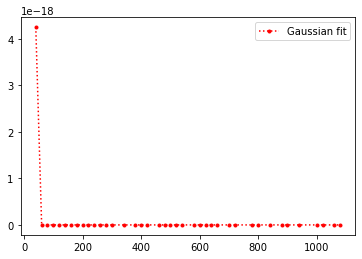

In [12]:
fig = plt.figure()

plt.plot(
    sizes,
    expon(sizes, *param_optimised_e),
    'r.:',
    label = 'Gaussian fit'
)
plt.legend()

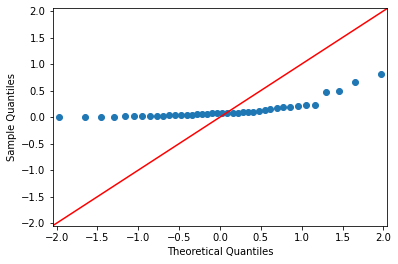

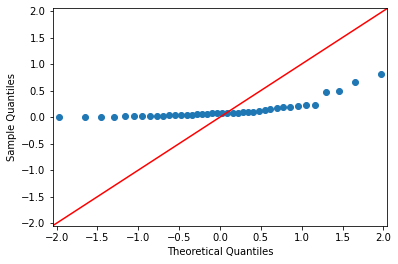

In [13]:
sm.qqplot(num_edges, line ='45')